# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


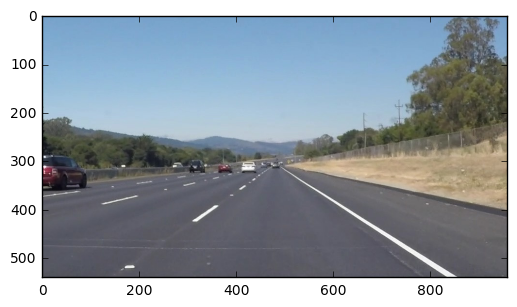

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [5]:
def remove_outliers(segments):
    """
    Remove outliers segments. This should reduce noise in segments picked up.
    """
    return segments

In [6]:
def segment(m, b, y1, y2):
    """
    Return a segment as a tuple (x1, y1, x2, y2)
    
    y = mx + b
    """
    x1 = m!=0 and (y1-b)/m or 0
    x2 = m!=0 and (y2-b)/m or 0
    return (x1, y1, x2, y2)

def smooth_value(old_value, new_value, alpha=0.8):
    """
    Smooth value from old to new.
    This is a weighted changed between old and new value
    """
    return math.floor((alpha)*old_value + (1-alpha)*new_value)

def get_left_and_right_lines(lines):
    """
    Return a tuple (l, r) containing left and right lines. 
    `lines` containes at most two segments defining left and right lines (no order enforced)
    """
    l = None
    r = None
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (x2-x1) != 0 and (y2-y1)/(x2-x1) or 0       
            if (m < 0):
                l = [x1,y1,x2,y2]
            else:
                r = [x1,y1,x2,y2]
    
    return l, r

def smooth_with_previous_state(old_lanes, new_lanes):
    """
    Smooth out left and right lanes with lanes of previous frame
    
    `old_lanes` 
    `new_lanes` 
    """
    # First frame of the video
    if len(old_lanes) == 0:
        return new_lanes
    
    left_old, right_old = get_left_and_right_lines(old_lanes)            
    left_new, right_new = get_left_and_right_lines(new_lanes)
    
    # Smooth out left lane
    if left_old is not None and left_new is not None:
        left_new[0] = smooth_value(left_old[0], left_new[0])
        left_new[2] = smooth_value(left_old[2], left_new[2])
     
    # Smooth out right lane
    if right_old is not None and right_new is not None:
        right_new[0] = smooth_value(right_old[0], right_new[0])
        right_new[2] = smooth_value(right_old[2], right_new[2])
        
    # Compose output    
    smooth_lanes = []    
    if left_new is not None:
        smooth_lanes.append(left_new)
        
    if right_new is not None:
        smooth_lanes.append(right_new)
    
    return np.array([smooth_lanes], dtype=np.int32)

def process_left_and_right_lanes(image, lines):
    """
    Extrapolates lines by creating two buckets left and right and then averaging lines equation parameters.
    """
    m_threshold = 0.08
    b_threshold = 35

    # min y is taken from left and right lane.
    # Left and right lanes will always have the same min and max y
    minY = image.shape[0]
    maxY = image.shape[0]
    
    # Create two buckets, one for left line another for right line
    left = []
    right = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            minY = min(minY,y1,y2)
            m = (x2-x1) != 0 and (y2-y1)/(x2-x1) or 0       
            b = y1-m*x1
            if (m < 0):
                bucket = left
            else:
                bucket = right
            bucket.append([m, b])
          
    # Data set can be noisy, we should remove outliers    
    left = remove_outliers(left)
    right = remove_outliers(right)

    # Get mean for `m` and `b`
    result = []
    if len(left):
        mean = np.mean(left, 0);
        m = mean[0]
        b = mean[1]
        #print('Left m', m, ", b", b, ", minY", minY)
        line = segment(m, b, minY, maxY)
        result.append(line)

    if len(right):
        mean = np.mean(right, 0);
        m = mean[0]
        b = mean[1]
        #print('Right m', m, ", b", b, ", minY", minY)
        line = segment(m, b, minY, maxY)
        result.append(line)
    
    return np.array([result], dtype=np.int32)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
mask vertices x: [110, 440, 530, 910, 110]
mask vertices y: [540, 320, 320, 540, 540]


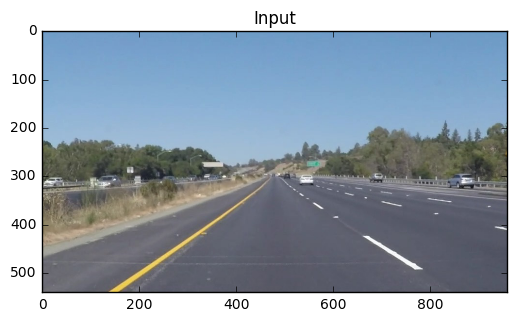

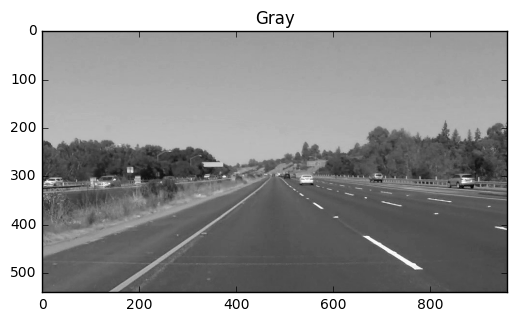

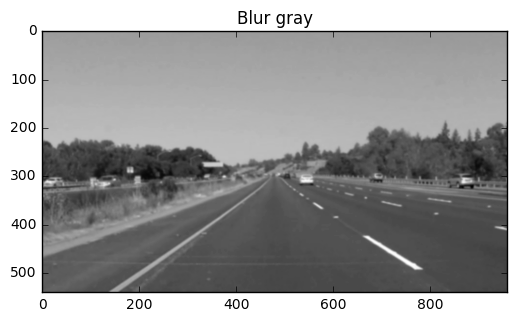

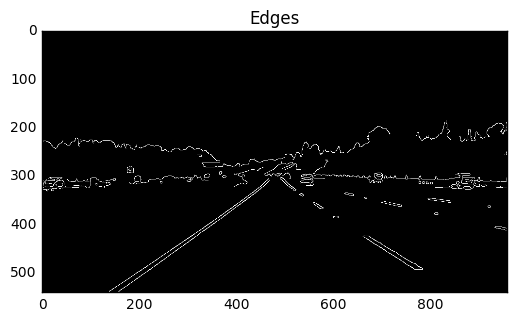

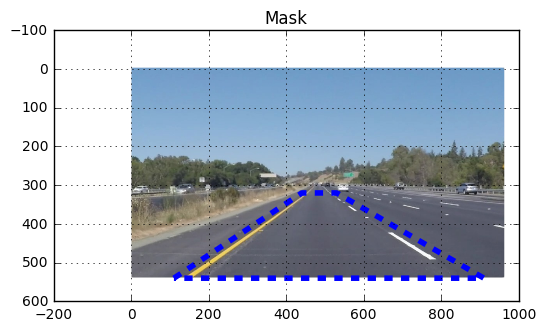

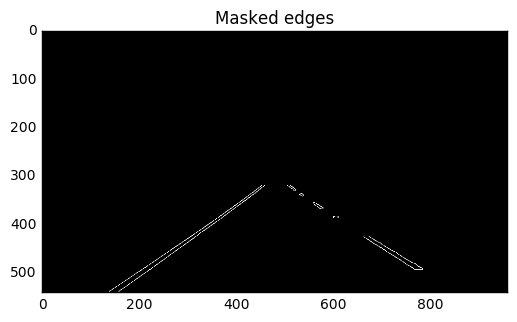

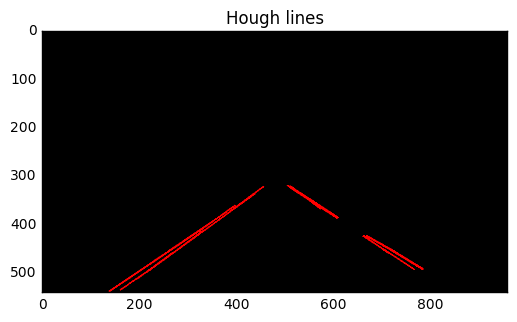

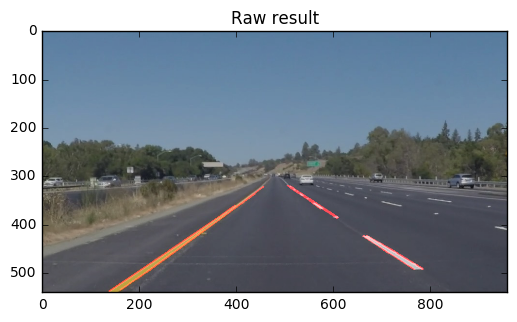

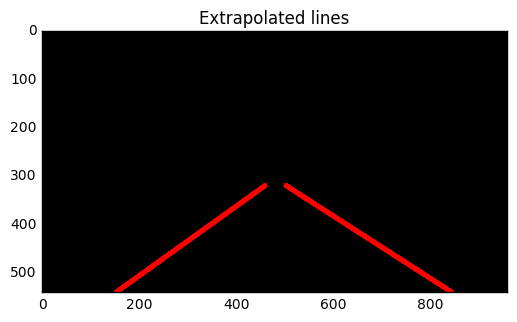

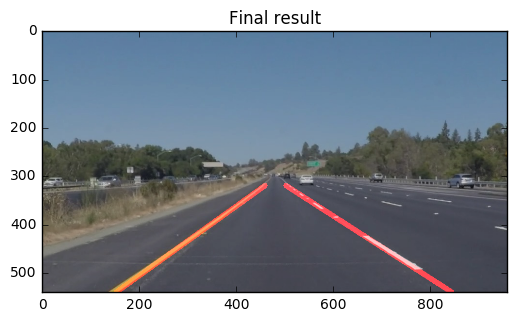

In [7]:
show_inter=True
use_edge_detect=True #True to use edge detect, false to use color select

#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.figure()
plt.imshow(image)
plt.title("Input")

# Convert to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

if not use_edge_detect:
    # Select white
    lower_white = np.array([0,0,150], dtype=np.uint8)
    upper_white = np.array([30,50,255], dtype=np.uint8)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    if show_inter:
        plt.figure()
        plt.imshow(white_mask, cmap='gray')
        plt.title("White mask")

    # Select yellow
    lower_yellow = np.array([90,15,110], dtype=np.uint8)
    upper_yellow = np.array([150,180,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    if show_inter:
        plt.figure()
        plt.imshow(yellow_mask, cmap='gray')
        plt.title("Yellow mask")

    # Combine white and yellow selection
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    if show_inter:
        plt.figure()
        plt.imshow(color_mask, cmap='gray')
        plt.title("White and yellow mask")

    color_img = cv2.bitwise_and(image, image, mask=color_mask)
    if show_inter:
        plt.figure()
        plt.imshow(color_img)
        plt.title("White and yellow select")    

    edges_img, contours, hierarchy = cv2.findContours(color_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if show_inter:
        plt.figure()
        plt.imshow(edges_img, cmap='gray')
        plt.title("Contours of white and yellow select")
else:
    gray_img = grayscale(image)
    if show_inter:
        plt.figure()
        plt.imshow(gray_img, cmap='gray')
        plt.title("Gray")

    kernel_size = 7
    blur_gray_img = gaussian_blur(gray_img, kernel_size)
    if show_inter:
        plt.figure()
        plt.imshow(blur_gray_img, cmap='gray')
        plt.title("Blur gray")

    low_threshold = 50
    high_threshold = 150
    edges_img = canny(blur_gray_img, low_threshold, high_threshold)
    if show_inter:
        plt.figure()
        plt.imshow(edges_img, cmap='gray')
        plt.title("Edges")
    
imshape = image.shape
mask_left=(110, imshape[0])
mask_apex_left=(440, 320)
mask_apex_right=(530, 320)
mask_right=(910, 540)
vertices = np.array([[mask_left, mask_apex_left, mask_apex_right, mask_right, (imshape[1],imshape[0])]], dtype=np.int32)
if show_inter:
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0], vertices[0][0][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1], vertices[0][0][1]]
    print('mask vertices x:', x)
    print('mask vertices y:', y)
    plt.figure()
    plt.imshow(image)
    plt.plot(x, y, 'b--', lw=4)
    plt.title("Mask")
    plt.grid(True)

masked_edges_img = region_of_interest(edges_img, vertices)
if show_inter:
    plt.figure()
    plt.imshow(masked_edges_img, cmap='gray')
    plt.title("Masked edges")

rho = 2
theta = np.pi/180
threshold = 25
min_line_len = 50
max_line_gap = 30
lines = cv2.HoughLinesP(masked_edges_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
lines_img = np.zeros((*masked_edges_img.shape, 3), dtype=np.uint8)
draw_lines(lines_img, lines)
if show_inter:
    plt.figure()
    plt.imshow(lines_img, cmap='gray')
    plt.title("Hough lines")
    
raw_lines_img = weighted_img(lines_img, image)
plt.figure()
plt.imshow(raw_lines_img)
plt.title("Raw result")

extrapolated_lines = process_left_and_right_lanes(image, lines)
extrapolated_lines_img = np.zeros((*masked_edges_img.shape, 3), dtype=np.uint8)
draw_lines(extrapolated_lines_img, extrapolated_lines, thickness=10)
if show_inter:
    plt.figure()
    plt.imshow(extrapolated_lines_img, cmap='gray')
    plt.title("Extrapolated lines")

result_img = weighted_img(extrapolated_lines_img, image)
plt.figure()
plt.imshow(result_img)
plt.title("Final result")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
# Global to smooth lines from frame to frame
old_lanes = []

use_edge_detect=True #True to use edge detect, false to use color select
# Color select works better for the extra challenge

def init_video_processing():
    """
    Reset a few internal state before starting video processing
    """
    global old_lanes
    old_lanes = []

def process_image(image):    
    global old_lanes
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if not use_edge_detect:
        # Select white
        lower_white = np.array([0,0,150], dtype=np.uint8)
        upper_white = np.array([100,50,255], dtype=np.uint8)
        white_mask = cv2.inRange(hsv, lower_white, upper_white)

        # Select yellow
        lower_yellow = np.array([90,100,100], dtype=np.uint8)
        upper_yellow = np.array([110,200,255], dtype=np.uint8)
        yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
        # Combine white and yellow selection
        color_mask = cv2.bitwise_or(white_mask, yellow_mask)
        
        edges_img, contours, hierarchy = cv2.findContours(color_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        # Gray
        gray_img = grayscale(image)

        # Blur
        kernel_size = 5
        blur_gray_img = gaussian_blur(gray_img, kernel_size)

        # Edge
        low_threshold = 80
        high_threshold = 150
        edges_img = canny(blur_gray_img, low_threshold, high_threshold)
    
    # Mask edges
    imshape = image.shape
    mask_left=(int(110/960*imshape[1]), imshape[0])
    mask_apex_left=(int(440/960*imshape[1]), int(320/540*imshape[0]))
    mask_apex_right=(int(530/960*imshape[1]), int(320/540*imshape[0]))
    mask_right=(int(910/960*imshape[1]), int(540/540*imshape[0]))
    vertices = np.array([[mask_left, mask_apex_left, mask_apex_right, mask_right, (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges_img = region_of_interest(edges_img, vertices)
    
    # Detect lines
    rho = 2
    theta = np.pi/180
    threshold = 25
    min_line_len = 65
    max_line_gap = 30
    lines = cv2.HoughLinesP(masked_edges_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    # Get left and right lines
    r_l_lanes = process_left_and_right_lanes(image, lines)
    # Smooth out with previous frame
    smooth_r_l_lanes = smooth_with_previous_state(old_lanes, r_l_lanes)
    old_lanes = smooth_r_l_lanes

    # Draw lines
    smooth_lanes_img = np.zeros((*masked_edges_img.shape, 3), dtype=np.uint8)
    draw_lines(smooth_lanes_img, smooth_r_l_lanes, thickness=10)

    result = weighted_img(smooth_lanes_img, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
init_video_processing()
use_edge_detect=True 
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 73.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.42 s, sys: 622 ms, total: 4.05 s
Wall time: 3.26 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
init_video_processing()
use_edge_detect=True 
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 70.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.7 s, sys: 1.98 s, total: 13.7 s
Wall time: 10.1 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Implemented pipeline relies only on:
1. Edge detection (or color selection)
2. Filter everything out of region of interest
3. Lines detection
4. Left and right lanes selection

Shortcomings:
1. The current pipeline relies solely on edge detections, which doesn't work for the extra challenge. Color selection could be used first to remove most of the noise and then we could compute contours.
2. During the lines detection phase, we should play stats and remove outliers lines. This is yet another way to remove the noise picked up by the pipeline.
3. The region of interest is hard-coded and tightly surround the lanes, that's one of the reason for the extra challenge to not work at first try (960x540 vs 1280x720). Our approach to hardcode works great on the dataset but it's not how it will work in real life. If noise reduction is correctly implemented we could make the region of interest larger and maybe detect the horizon to define a height cut off.
4. Detecting lines doesn't work for curves. Curves are `curvy`, right now we only detect straight lines. I've not enough knownlegde on this subject.
5. Lanes in urban or downtown area are more complex than given dataset. For instance the color yellow and white can be  used to indicate other things than lanes: carpool lane, arrows, pedestrian crossing. Current pipeline will edge detect those and color filtering will not help either.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
init_video_processing()
use_edge_detect=False
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.98 s, sys: 1.49 s, total: 9.47 s
Wall time: 8.43 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))